# Trabalho A2 - Banco de Dados
## Tema : UFC Lutas
#### Link  Base de Dados : https://www.kaggle.com/mdabbert/ultimate-ufc-dataset?select=ufc-master.csv

### Alunos: Germano Andrade e João Alcindo

In [25]:
import os
import operator
import codecs
import random
import math
import json
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pylab as pl
import pandas as pd
import networkx as nx

from collections import Counter, OrderedDict

import urllib
from bs4 import BeautifulSoup
#import pydot

#import datashader as ds
#import datashader.transfer_functions as tf
#from datashader.layout import random_layout, circular_layout, forceatlas2_layout
#from datashader.bundling import connect_edges, hammer_bundle

#import holoviews.operation.datashader as hd
#import holoviews as hv
#hv.extension("bokeh")

from SPARQLWrapper import SPARQLWrapper, JSON    #sudo pip3 install --upgrade SPARQLWrapper

from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline

In [61]:
#Lendo o csv:
df = pd.read_csv("./Databases/ufc-master.csv")

#Filtrando os dados desejados:
df = df[["R_fighter","B_fighter","date","location","country","Winner","title_bout","weight_class","gender","R_age","B_age"]] 

In [62]:
# Imprimindo os 10 primeiros dados:
df.head(10)

,R_fighter,B_fighter,date,location,country,Winner,title_bout,weight_class,gender,R_age,B_age
0,Thiago Santos,Glover Teixeira,11/7/2020,"Las Vegas, Nevada, USA",USA,Blue,False,Light Heavyweight,MALE,36,41
1,Andrei Arlovski,Tanner Boser,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Heavyweight,MALE,41,29
2,Raoni Barcelos,Khalid Taha,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Bantamweight,MALE,33,28
3,Claudia Gadelha,Yan Xiaonan,11/7/2020,"Las Vegas, Nevada, USA",USA,Blue,False,Women's Strawweight,FEMALE,31,31
4,Trevin Giles,Bevon Lewis,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Middleweight,MALE,28,29
5,Giga Chikadze,Jamey Simmons,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Featherweight,MALE,32,28
6,Alexandr Romanov,Marcos Rogerio de Lima,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Heavyweight,MALE,29,35
7,Darren Elkins,Eduardo Garagorri,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Featherweight,MALE,36,31
8,Max Griffin,Ramiz Brahimaj,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Welterweight,MALE,34,27
9,Gustavo Lopez,Anthony Birchak,11/7/2020,"Las Vegas, Nevada, USA",USA,Red,False,Bantamweight,MALE,31,34


In [63]:
#Criando novas colunas no dataframe:
df['Winner_w'] = np.NaN
df['Loser'] = np.NaN
df['W_age'] = np.NaN
df['L_age'] = np.NaN

#Adicionando os vencedores na coluna Winner e os perdedores na coluna Loser,
#o mesmo com as idades nas respectivas colunas(W_age,L_age):
for index, row in df.iterrows():
    if row['Winner'] == "Blue":
        df.loc[index,'Winner_w'] =  df.loc[index,'B_fighter']
        df.loc[index,'Loser'] =  df.loc[index,'R_fighter']
        df.loc[index,'W_age'] =  df.loc[index,'B_age']
        df.loc[index,'L_age'] =  df.loc[index,'R_age']
    elif row['Winner'] == "Red":
        df.loc[index,'Winner_w'] =  df.loc[index,'R_fighter']
        df.loc[index,'Loser'] =  df.loc[index,'B_fighter']
        df.loc[index,'W_age'] =  df.loc[index,'R_age']
        df.loc[index,'L_age'] =  df.loc[index,'B_age']

In [64]:
#Filtrando novamente os dados, agora retirando as colunas R_fighter,B_fighter, Winner, R_age e B_age:
df = df[["Winner_w","Loser","date","location","country","title_bout","weight_class","gender","W_age","L_age"]] 

#Renomeando a coluna Winner_w, chamando a de Winner:
df.rename(columns={'Winner_w':'Winner'}, inplace=True)

In [65]:
# Imprimindo os 10 primeiros dados:
df.head(10)

,Winner,Loser,date,location,country,title_bout,weight_class,gender,W_age,L_age
0,Glover Teixeira,Thiago Santos,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Light Heavyweight,MALE,41.0,36.0
1,Andrei Arlovski,Tanner Boser,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Heavyweight,MALE,41.0,29.0
2,Raoni Barcelos,Khalid Taha,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Bantamweight,MALE,33.0,28.0
3,Yan Xiaonan,Claudia Gadelha,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Women's Strawweight,FEMALE,31.0,31.0
4,Trevin Giles,Bevon Lewis,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Middleweight,MALE,28.0,29.0
5,Giga Chikadze,Jamey Simmons,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Featherweight,MALE,32.0,28.0
6,Alexandr Romanov,Marcos Rogerio de Lima,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Heavyweight,MALE,29.0,35.0
7,Darren Elkins,Eduardo Garagorri,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Featherweight,MALE,36.0,31.0
8,Max Griffin,Ramiz Brahimaj,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Welterweight,MALE,34.0,27.0
9,Gustavo Lopez,Anthony Birchak,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Bantamweight,MALE,31.0,34.0


In [66]:
df["year"] = [i[-4:] for i in df["date"]]
df.head(5)

,Winner,Loser,date,location,country,title_bout,weight_class,gender,W_age,L_age,year
0,Glover Teixeira,Thiago Santos,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Light Heavyweight,MALE,41.0,36.0,2020
1,Andrei Arlovski,Tanner Boser,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Heavyweight,MALE,41.0,29.0,2020
2,Raoni Barcelos,Khalid Taha,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Bantamweight,MALE,33.0,28.0,2020
3,Yan Xiaonan,Claudia Gadelha,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Women's Strawweight,FEMALE,31.0,31.0,2020
4,Trevin Giles,Bevon Lewis,11/7/2020,"Las Vegas, Nevada, USA",USA,False,Middleweight,MALE,28.0,29.0,2020


### Descrição do Dataframe:

|Coluna|Tipo|Descrição|  
|:-|:-|:-|
|**Winner**|varchar(45)| Vencedor da luta|  
|**Loser**|varchar(45)| Perdedor da luta|   
|**date**|datetime| Dia da luta|   
|**location**|varchar(45)| Cidade, Estado e país onde ocorreu a luta|   
|**country**|varchar(30)|  País em que a luta ocorreu|  
|**title_bout**|boolean| Indica se a luta valia disputa de cinturão ou não|   
|**weight_class**|varchar(25)|  Categoria de peso|  
|**gender**|varchar(10)|  Gênero dos lutadores|  
|**W_age**|decimal(3,1)|  Idade do vencedor|  
|**L_age**|decimal(3,1)|  Idade do perdedor|  
|**year**|int(4)| Ano em que ocorreu a luta|

In [20]:
df_ori = df

In [10]:
for idx in df.index:
    if not G.has_edge(df.loc[idx,'Loser'],df.loc[idx,'Winner']):
        G.add_edge(df.loc[idx,'Loser'],df.loc[idx,'Winner'], frequency = 1)
    else:
        G.edges[df.loc[idx,'Loser'],df.loc[idx,'Winner']]['frequency'] += 1

In [9]:
df = df[df['weight_class']=="Light Heavyweight"]
G = nx.DiGraph()
#add nodes
for idx in df.index:
    if df.loc[idx,'Winner'] not in G:
        G.add_node(df.loc[idx,'Winner'],frequency=1)
    else:
        G.nodes[df.loc[idx,'Winner']]['frequency'] +=1
    
    if df.loc[idx,'Loser'] not in G:
        G.add_node(df.loc[idx,'Loser'],frequency=1)
        

In [11]:
#nx.draw_networkx(G)

print('Number of nodes is: {}'.format(G.number_of_nodes()))
print('Number of edges is: {}'.format(G.number_of_edges()))

Number of nodes is: 175
Number of edges is: 357


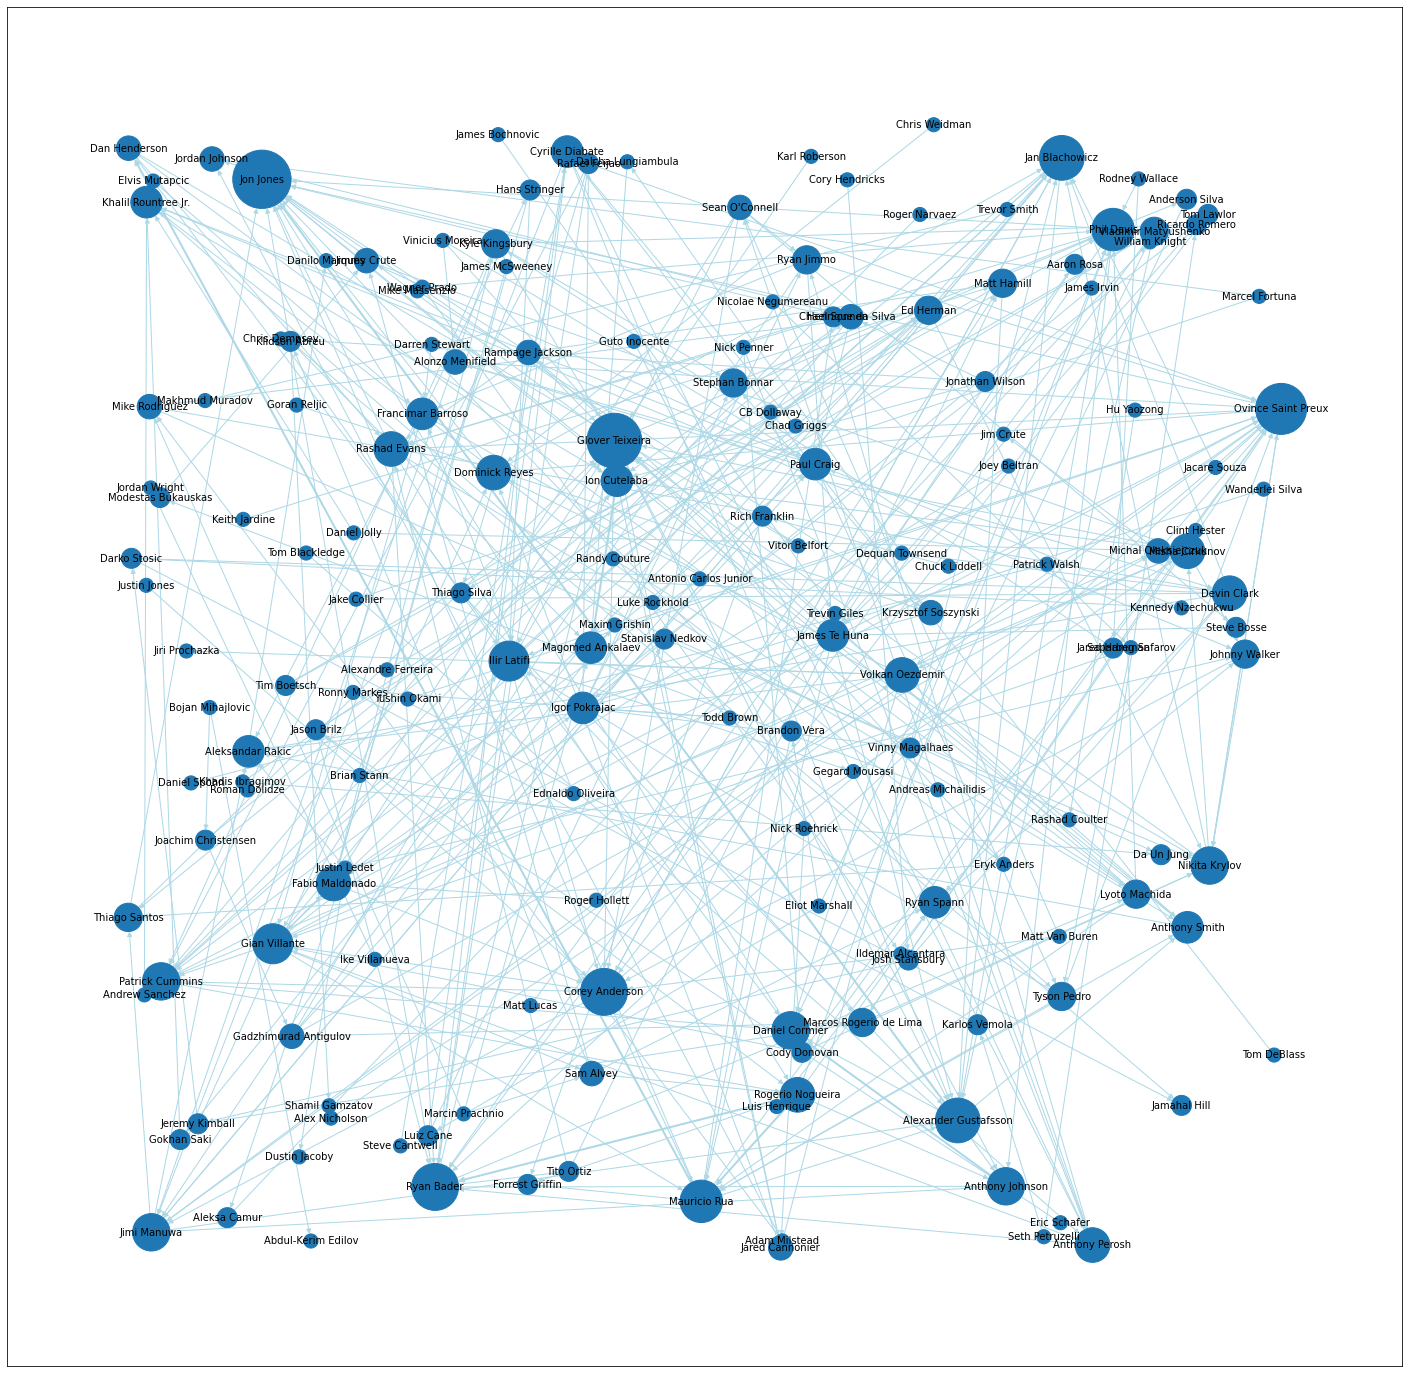

In [13]:
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("UFC Graph")
pos = nx.random_layout(G, seed=1)

nx.draw_networkx(G,
                node_size=[200*nx.get_node_attributes(G,'frequency')[g] for g in G.nodes()],
                pos = pos,
                width=list(nx.get_edge_attributes(G,'frequency').values()),
                edge_cmap=None,
                edge_vmin=None,
                edge_vmax=None,
                edge_color = "lightblue",
                style='solid',
                labels=None ,
                font_size=10,
                #font_color='blue',
                font_weight='normal',
                font_family='sans-serif',
                label='FGraph')

https://networkx.org/documentation/stable/reference/readwrite/json_graph.html

In [26]:
with open('./Databases/ufc.json', 'w') as f:
    f.write(json.dumps(nx.cytoscape_data(G)))

In [27]:
with open('./Databases/ufc.json', 'r') as f:
    data = json.loads(f.read())
    
for element in data['elements']:
    print(element)

nodes
edges


### https://dash.plotly.com/cytoscape  
### https://github.com/plotly/dash-cytoscape  
### https://medium.com/plotly/introducing-dash-cytoscape-ce96cac824e4  
### https://github.com/plotly/dash-cytoscape/blob/master/demos/usage-concentric-social-network.py  

In [33]:
import json
import dash
import urllib.request
import dash_html_components as html
from dash.dependencies import Input, Output
import dash_cytoscape as cyto

app = dash.Dash(__name__)
app.title = "UFC Graph"
server = app.server

app.scripts.config.serve_locally = True
app.css.config.serve_locally = True


with open('./Databases/ufc.json', 'r') as f:
    data = json.loads(f.read())
    
#https://github.com/plotly/dash-cytoscape/blob/master/demos/data/edge-types/cy-style.json
with open('./Databases/cy-style.json') as f:
    stylesheet = json.loads(f.read())

styles = {
    'container': {
        'position': 'fixed',
        'display': 'flex',
        'flex-direction': 'column',
        'height': '100%',
        'width': '100%'
    },
    'cy-container': {
        'flex': '1',
        'position': 'relative'
    },
    'cytoscape': {
        'position': 'absolute',
        'width': '100%',
        'height': '100%',
        'z-index': 999
    }
}


# App
app.layout = html.Div(style=styles['container'], children=[
    html.Div([
        html.Button("Responsive Toggle", id='toggle-button'),
        html.Div(id='toggle-text')
    ]),
    html.Div(className='cy-container', style=styles['cy-container'], children=[
        cyto.Cytoscape(
            id='cytoscape',
            elements=data['elements'],
            stylesheet=stylesheet,
            style=styles['cytoscape'],
            layout={
                'name': 'cose',
                'idealEdgeLength': 100,
                'nodeOverlap': 20,
                'refresh': 20,
                'fit': True,
                'padding': 30,
                'randomize': False,
                'componentSpacing': 100,
                'nodeRepulsion': 400000,
                'edgeElasticity': 100,
                'nestingFactor': 5,
                'gravity': 80,
                'numIter': 1000,
                'initialTemp': 200,
                'coolingFactor': 0.95,
                'minTemp': 1.0
            },
            responsive=True
        )
    ])
])


@app.callback(Output('cytoscape', 'responsive'), [Input('toggle-button', 'n_clicks')])
def toggle_responsive(n_clicks):
    n_clicks = 2 if n_clicks is None else n_clicks
    toggle_on = n_clicks % 2 == 0
    return toggle_on


@app.callback(Output('toggle-text', 'children'), [Input('cytoscape', 'responsive')])
def update_toggle_text(responsive):
    return '\t' + 'Responsive ' + ('On' if responsive else 'Off')

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Acesso negado: 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\dash_renderer\\__init__.py'
Consider using the `--user` option or check the permissions.



  Created wheel for dash: filename=dash-1.17.0-py3-none-any.whl size=83731 sha256=ca4a04d6915823f65c31e241f7ee10fa94decaceea24eb10cae0f472c749a42b
  Stored in directory: c:\users\germa\appdata\local\pip\cache\wheels\fc\16\5c\549c935a88b11f2340725457d3135bc1d0900757fec1b98031
  Created wheel for dash-renderer: filename=dash_renderer-1.8.3-py3-none-any.whl size=1013949 sha256=097ae598a6fe78c814a241b945c22ee5c7d6e897c5db0dfbd0536ab7f79472a1
  Stored in directory: c:\users\germa\appdata\local\pip\cache\wheels\82\4d\8c\0764de014b25313cf54199f212bad4fb4b228ecfaef58be3b9
  Created wheel for dash-core-components: filename=dash_core_components-1.13.0-py3-none-any.whl size=3513146 sha256=b3a99111540f1900243e46eba1a496e824ef407d6caafa94e222f6a8cc89e0e3
  Stored in directory: c:\users\germa\appdata\local\pip\cache\wheels\42\a5\88\62859b46d766dd1089b37ff67fc4286053f6047df9aa33f47e
  Created wheel for dash-html-components: filename=dash_html_components-1.1.1-py3-none-any.whl size=427900 sha256=71788

### Help you to deploy on Heroku
https://dashboard.heroku.com/apps/adagraphs/deploy/heroku-git  
https://devcenter.heroku.com/articles/heroku-cli#verifying-your-installation  
https://www.geeksforgeeks.org/deploy-python-flask-app-on-heroku/